## Import necessary modules

In [7]:
import time
import pandas as pd
import numpy as np
import datetime as dt
from collections import OrderedDict
from copy import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

## Filepath management

In [8]:
project_dir = r'/Users/hudson/Code/marketModel/'

## Load the data from the hdf store

In [9]:
stock_data = pd.read_hdf(project_dir + 'data/stock_data/raw_stock_data.hdf', 'table')
symbols = stock_data.reset_index().ticker.unique()
pprint(symbols)

array(['ASTC', 'PAVM', 'CODA', 'WSTL', 'MICR', 'SEAC', 'GBR', 'CPST',
       'CYAN', 'ATLC', 'WTT', 'LRAD', 'DTRM', 'AVIR', 'UTSI', 'JCS',
       'ZDGE', 'REFR', 'FORD', 'APHB', 'JVA', 'VSR', 'BNSO', 'ARDM', 'LEU',
       'MOC'], dtype=object)


In [26]:
symbol = np.random.choice(symbols)
print 'symbol: ' + symbol
stock_data_vis = stock_data.loc[symbol]
print stock_data_vis.head()
print stock_data_vis.describe()
print stock_data.reset_index().loc[:,('ticker', 'timestamp')].groupby('ticker').agg([len, np.min, np.max])

symbol: DTRM
                      open   high    low  close  volume
timestamp                                              
2017-08-09 13:30:00  1.960  1.960  1.960  1.960     125
2017-08-09 13:45:00  1.980  1.980  1.980  1.980    1196
2017-08-09 13:46:00  1.990  1.990  1.990  1.990     100
2017-08-09 13:51:00  1.965  1.965  1.965  1.965     100
2017-08-09 14:09:00  1.980  1.980  1.980  1.980     300
             open        high         low       close         volume
count  661.000000  661.000000  661.000000  661.000000     661.000000
mean     1.911314    1.915366    1.908221    1.912121    1565.998487
std      0.138369    0.137826    0.139136    0.138769   21054.810817
min      1.600000    1.600000    1.580000    1.600000     100.000000
25%      1.850000    1.850000    1.850000    1.850000     100.000000
50%      1.960000    1.960000    1.950000    1.950700     200.000000
75%      2.010000    2.010000    2.010000    2.010000     571.000000
max      2.120000    2.120000    2.120000  

## Visualize the data

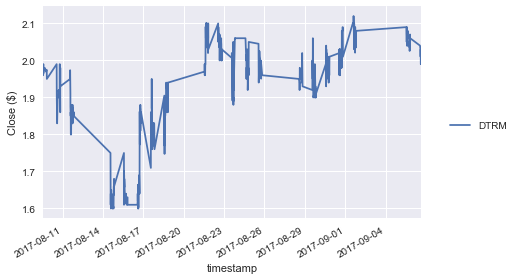

In [27]:
# First keep the time index so we can see the time frame
stock_data_vis.close.plot(label=symbol)

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

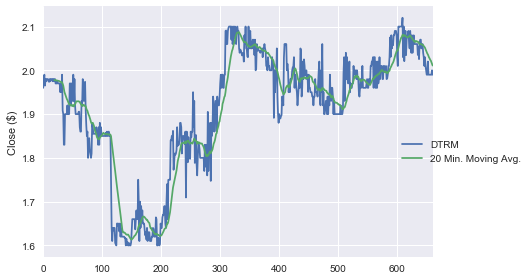

In [28]:
# Now drop the time index so we can see the actual stock movement
stock_data_vis.reset_index().close.plot(label=symbol)
stock_data_vis.reset_index().close.rolling(20).mean().plot(label='20 Min. Moving Avg.')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

## Adding in missing times (zero volume minutes)
Before evaluating goals, we need to fill in the missing time steps.
These missing time steps have zero trading volume.
So, all of the prices for these steps are equal to the last
closing price. All of the volumes are equal to zero.

In [53]:
# First reshape the index and group by ticker
stock_data_final = stock_data.reset_index(level=0)
grouped_stock_data = stock_data_final.groupby('ticker')

In [74]:
## Before evaluating goals, we need to fill in the missing time steps.
## These missing time steps have zero trading volume.
## So, all of the prices for these steps are equal to the last
## closing price. All of the volumes are equal to zero.

stock_data_with_all_minutes = []
for name, group in grouped_stock_data:
    
    # Create a dataframe of all the times
    min_time, max_time = group.index.min(), group.index.max()
    timeDiff = (max_time - min_time).components
    numMinutes = timeDiff.days*24*60 + timeDiff.hours*60 + timeDiff.minutes

    #alltimesIdx = pd.DatetimeIndex(start=min_time, freq=pd.tseries.offsets.Minute(1), periods=numMinutes)
    alltimesIdx = pd.DatetimeIndex(start=min_time, freq=pd.Timedelta(minutes=1), periods=numMinutes)
    alltimes = pd.DataFrame(index=alltimesIdx)

    # Drop minutes outside of 9:30am - 4:00pm est
    alltimes = alltimes.between_time('09:30','16:00')
  
    # Join on the original dataframe
    alltimes_group = alltimes.join(group)
    
    # Forward fill the NaN closing prices 
    alltimes_group.loc[:,('ticker', 'close')] = alltimes_group.loc[:,('ticker', 'close')].\
                                                    fillna(method='ffill', axis=0)
    
    # Assign all price variables to the close price
    alltimes_group.loc[:,'open':'close'] = alltimes_group.loc[:,'open':'close'].\
                                                fillna(method='bfill', axis=1)
    
    # Assign all NaN volumes to zero
    alltimes_group.loc[:, 'volume'] = alltimes_group.loc[:, 'volume'].fillna(value=0)
    
    stock_data_with_all_minutes.append(alltimes_group)
    
stock_data_with_all_minutes = pd.concat(stock_data_with_all_minutes)
stock_data_with_all_minutes.index.name = 'timestamp'

In [76]:
stock_data_with_all_minutes.reset_index().loc[:,('ticker', 'timestamp')].groupby('ticker').agg([len, min, max])

timestamp                                        
             len                 min                 max
ticker                                                  
APHB       11093 2017-08-09 13:30:00 2017-09-06 15:54:00
ARDM       11091 2017-08-09 13:30:00 2017-09-06 15:52:00
ASTC       11089 2017-08-09 13:30:00 2017-09-06 15:50:00
ATLC       11031 2017-08-09 13:30:00 2017-09-06 14:52:00
AVIR       11089 2017-08-09 13:30:00 2017-09-06 15:50:00
BNSO       10673 2017-08-09 14:05:00 2017-09-05 16:00:00
CODA       10986 2017-08-09 14:30:00 2017-09-06 15:07:00
CPST       11096 2017-08-09 13:30:00 2017-09-06 15:57:00
CYAN       10621 2017-08-10 13:30:00 2017-09-06 14:33:00
DTRM       11096 2017-08-09 13:30:00 2017-09-06 15:57:00
FORD       11079 2017-08-09 13:30:00 2017-09-06 15:40:00
GBR        11089 2017-08-09 13:38:00 2017-09-06 15:58:00
JCS        11092 2017-08-09 13:30:00 2017-09-06 15:53:00
JVA        10991 2017-08-09 14:04:00 2017-09-06 14:46:00
LEU        11081 2017-08-09 13:30:00 2017-09-06 15:42:00
LRAD       11046 2017-08-09 13:30:00 2017-09-06 15:07:00
MICR       11038 2017-08-09 14:05:00 2017-09-06 15:34:00
MOC        11016 2017-08-09 14:27:00 2017-09-06 15:34:00
PAVM       10952 2017-08-09 15:49:00 2017-09-06 15:52:00
REFR       11096 2017-08-09 13:30:00 2017-09-06 15:57:00
SEAC       11082 2017-08-09 13:45:00 2017-09-06 15:58:00
UTSI       11074 2017-08-09 13:45:00 2017-09-06 15:50:00
VSR        11095 2017-08-09 13:30:00 2017-09-06 15:56:00
WSTL       11058 2017-08-09 13:30:00 2017-09-06 15:19:00
WTT        11052 2017-08-09 14:14:00 2017-09-06 15:57:00
ZDGE       11016 2017-08-09 13:30:00 2017-09-06 14:37:00

## Logic for getting goal information

In [96]:
def get_min_max(data, starttime, endtime):
    """
    This function takes data for a specific ticker and returns the min and max prices.
    """
    subdata = data.loc[starttime:endtime]
    
    return (subdata.low.min(), subdata.high.max())
    
def is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac = 0.1, goal_drop_frac=0.1):
    """
    This function takes data for a specific ticker, a time index for that ticker, goal parameters, and 
    returns a boolean indicating whether or not the goal is satisfied for that timestep.
    """
    
    # Assign a status message to record various special cases
    statusMessage = ""
    
    #Convert time variables to appropriate numpyt date types
    td_goal_time_from_step = np.timedelta64(goal_time_from_step, 'm')
    td_goal_duration = np.timedelta64(goal_duration, 'm')
    
    # Calculate the start and end times of the goal time window
    goal_starttime = np.datetime64(timestep + td_goal_time_from_step)
    goal_endtime = np.datetime64(goal_starttime + td_goal_duration)
    
    if goal_endtime > np.datetime64(data.index.max()):
        statusMessage = "Goal time window end time lies beyond available data."
    
    # Get the data for goal checking in that time window
    subdata = data.loc[goal_starttime:goal_endtime]
    
    # Get the minimum and maximum prices for the goal time window
    min_price, max_price = get_min_max(data, goal_starttime, goal_endtime)
    if np.isnan(min_price) | np.isnan(max_price):
        # Zero trading volume in time window. Get last prices.
        most_recent_time_with_transactions = np.max(data.loc[:goal_starttime].index)
        if most_recent_time_with_transactions == timestep:
            statusMessage = statusMessage + " Zero trading volume between current timestep and goal time window end."
            return {'timestamp': timestep,
                    'goal_met': False,
                    'raise_goal_met': False,
                    'drop_goal_met': True,
                    'statusMessage': statusMessage}
        else:
            min_price, max_price = data.loc[timestep, 'low'], data.loc[timestep, 'high']
        
        
    # Determine if goals were met
    # TODO: is this the right reference for the 'current price'?
    current_price = np.mean(data.loc[timestep, ['high', 'close']])
    
    # Is raise goal met? Return true if max price at least (1+goal_raise_frac) * current_price
    is_raise_goal_met = max_price >= (1+goal_raise_frac) * current_price
    
    # Is drop goal met? Return true if min price at least (1-goal_drop_frac) * current_price
    is_drop_goal_met = min_price >= (1-goal_drop_frac) * current_price
    
    # Return dict containing raise and drop goals and product for convenience
    return {'timestamp': timestep,
        'goal_met': is_raise_goal_met * is_drop_goal_met, 
            'raise_goal_met': is_raise_goal_met, 
            'drop_goal_met': is_drop_goal_met,
             'statusMessage': statusMessage}

In [97]:
# test get_min_max
get_min_max(stock_data_vis, '2017-08-28', '2017-08-30')

(1.8999999999999999, 2.0600000000000001)

In [98]:
# test is_goal_met
random_time_index = np.random.choice(stock_data_vis.index.values)
print "Random time: " + str(random_time_index)
%timeit is_goal_met(stock_data_vis, random_time_index, 0, 1000)

Random time: 2017-08-21T13:35:00.000000000
1000 loops, best of 3: 1.46 ms per loop


## Get goal tags for all data

In [99]:
# first define a function that tags for one ticker
def get_tagged_stock_data(data, 
                          ticker, 
                          goal_time_from_step, 
                          goal_duration, 
                          goal_raise_frac = 0.1, 
                          goal_drop_frac=0.1):
    # Loop over the timestamps building a dictionary of the tagging information
    tagged_stock_data = []
    for timestep in data.index:
        goal_dict = is_goal_met(data, timestep, goal_time_from_step, goal_duration, goal_raise_frac, goal_drop_frac)
        tagged_stock_data.append(goal_dict)
    # Convert to pandas and return
    return pd.DataFrame(tagged_stock_data).set_index('timestamp')

In [100]:
start_delay = 24*60 # minutes
duration = 24*60*3 # minutes
raise_fraction = 0.05
drop_fraction = 0.05
list_tagged_tickers = []
for i, (symbol, group) in enumerate(stock_data_with_all_minutes.groupby('ticker')):
    print "Progress: {} of {} tickers. Current ticker: {}".format(i, len(symbols), symbol)
    
    # get the tag data for this symbol
    tag_data = get_tagged_stock_data(group, symbol, start_delay, duration, raise_fraction, drop_fraction)
    
    # join tag data back onto the group data
    merged_data = group.join(tag_data)
    
    # Append to the list of tagged data
    list_tagged_tickers.append(merged_data)
    
# Concatenate all the groups
all_tagged_data = pd.concat(list_tagged_tickers)

Progress: 0 of 26 tickers. Current ticker: APHB
Progress: 1 of 26 tickers. Current ticker: ARDM
Progress: 2 of 26 tickers. Current ticker: ASTC
Progress: 3 of 26 tickers. Current ticker: ATLC
Progress: 4 of 26 tickers. Current ticker: AVIR
Progress: 5 of 26 tickers. Current ticker: BNSO
Progress: 6 of 26 tickers. Current ticker: CODA
Progress: 7 of 26 tickers. Current ticker: CPST
Progress: 8 of 26 tickers. Current ticker: CYAN
Progress: 9 of 26 tickers. Current ticker: DTRM
Progress: 10 of 26 tickers. Current ticker: FORD
Progress: 11 of 26 tickers. Current ticker: GBR
Progress: 12 of 26 tickers. Current ticker: JCS
Progress: 13 of 26 tickers. Current ticker: JVA
Progress: 14 of 26 tickers. Current ticker: LEU
Progress: 15 of 26 tickers. Current ticker: LRAD
Progress: 16 of 26 tickers. Current ticker: MICR
Progress: 17 of 26 tickers. Current ticker: MOC
Progress: 18 of 26 tickers. Current ticker: PAVM
Progress: 19 of 26 tickers. Current ticker: REFR
Progress: 20 of 26 tickers. Current

In [122]:
#print all_tagged_data.goal_met.value_counts()
#print all_tagged_data.statusMessage.value_counts()
print all_tagged_data.groupby('ticker').agg({'goal_met': lambda x: x[x].shape[0],
'raise_goal_met': lambda x: x[x].shape[0],
'drop_goal_met': lambda x: x[x].shape[0]})

        drop_goal_met  goal_met  raise_goal_met
ticker                                         
APHB             8457      6737            7595
ARDM             7900      4619            5482
ASTC             3647      2441            2939
ATLC             7614      3009            3009
AVIR             6276      2160            2902
BNSO             7816       346             346
CODA             9843       803             803
CPST             9237      2000            2000
CYAN             9406      5874            5890
DTRM             7341      3883            3983
FORD            10620      3943            3943
GBR              7761      3782            4677
JCS              8693      2642            3114
JVA              9129        76              76
LEU              6406      2049            2094
LRAD            10899      5068            5069
MICR             6740      2728            2728
MOC              8435       684            1868
PAVM             8894      7778         

## Save data to hdf

In [123]:
all_tagged_data.to_hdf(project_dir + 'data/stock_data/tagged_stock_data.hdf', 'table')

/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:280: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:280: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_items] [items->None]

  f(store)
